# IMPORTS

In [1]:
# IMPORTS
import numpy as np
import random
import itertools
import json
import os
# Machine Learning imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, Input, LSTM, Flatten, Concatenate, Dense, Conv2D, TimeDistributed, MaxPooling2D, ReLU, Dropout, BatchNormalization, Activation, Lambda
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import Precision
from tensorflow.keras import backend as K
from tensorflow.keras.losses import sparse_categorical_crossentropy
import tensorflow_model_optimization
from tensorflow_model_optimization.sparsity.keras import strip_pruning
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_wrapper
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.python.core.sparsity.keras import pruning_callbacks
print("tensorflow version:", tf.__version__)
import keras
print("keras version:",keras.__version__)
import qkeras
from qkeras import QActivation, QDense, QConv2D, QBatchNormalization, QConv2DBatchnorm
from qkeras import quantized_relu, quantized_bits
from qkeras.utils import _add_supported_quantized_objects
from qkeras.autoqkeras.utils import print_qmodel_summary
print("qkeras version:",keras.__version__)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
# Display and plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from IPython.display import HTML, display
from PIL import Image
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import confusion_matrix
# Data management
import psutil
import h5py
# Memory management
import gc
# Notifications
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
from dotenv import load_dotenv
load_dotenv()
def send_email_notification(subject, content):
    sender_email = os.getenv('EMAIL_USER')
    receiver_email = "alexander.j.yue@gmail.com"
    password = os.getenv('EMAIL_PASS')

    message = MIMEMultipart()
    message["From"] = sender_email
    message["To"] = receiver_email
    message["Subject"] = subject
    body = content
    message.attach(MIMEText(body, "plain"))

    with smtplib.SMTP("smtp.gmail.com", 587) as server:
        server.starttls()
        server.login(sender_email, password)
        server.sendmail(sender_email, receiver_email, message.as_string())

# Memory monitoring functions
def print_memory_usage():
    memory = psutil.virtual_memory()
    print(f"Total memory: {memory.total / (1024**3):.2f} GB")
    print(f"Available memory: {memory.available / (1024**3):.2f} GB")
    print(f"Used memory: {memory.used / (1024**3):.2f} GB")
    print(f"Memory usage percentage: {memory.percent}%")

def print_cpu_usage():
    cpu_percent = psutil.cpu_percent(interval=1)
    print(f"CPU Usage: {cpu_percent}%")

2024-07-22 09:29:56.654464: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 09:29:56.746247: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-22 09:29:56.747336: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-22 09:29:59.030516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


tensorflow version: 2.13.1
keras version: 2.13.1
qkeras version: 2.13.1


# Dataset

In [2]:
# Load the pixel cluster to transverse momentum dataset into the input_data and target_data
def load_combine_shuffle_data_optimized_hdf5():
    # Load the dataset from Kenny's computer
    with h5py.File('/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/fl32_data_v3.hdf5', 'r') as h5f:
        combined_input = None
        combined_target = None

        for data_type in ['sig', 'bkg']:
            # Construct dataset names
            input_dataset_name = f'{data_type}_input'
            target_dataset_name = f'{data_type}_target'

            # Check if the dataset exists and load data sequentially
            if input_dataset_name in h5f and target_dataset_name in h5f:
                input_data = h5f[input_dataset_name][:].astype(np.float32)
                target_data = h5f[target_dataset_name][:].astype(np.float32)

                if combined_input is None:
                    combined_input = input_data
                    combined_target = target_data
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

                else:
                    print_memory_usage()
                    combined_input = np.vstack((combined_input, input_data))
                    combined_target = np.vstack((combined_target, target_data))
                    # Free memory of the loaded data
                    del input_data, target_data
                    gc.collect()

            else:
                print(f"Dataset {input_dataset_name} or {target_dataset_name} not found.")

        # Shuffling
        indices = np.arange(combined_input.shape[0])
        np.random.shuffle(indices)
        combined_input = combined_input[indices]
        combined_target = combined_target[indices]

        return combined_input, combined_target

In [10]:
def load_dataset():
    # Load dataset into memory
    input_data, target_data = load_combine_shuffle_data_optimized_hdf5()
    # Format the dataset into a 20x13x21 tensor (time, y, x)
    input_data = input_data.reshape(input_data.shape[0],20,13,21)
    return input_data, target_data

def process_dataset(input_data, target_data, hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    TRAIN_PT_THRESHOLD = hyperparams["TRAIN_PT_THRESHOLD"]
    TEST_PT_THRESHOLD = hyperparams["TEST_PT_THRESHOLD"]
    OUTPUT = hyperparams["OUTPUT"]
    

    # Split 80% of data into training data, 10% for validation data and 10% for testing data
    input_train_data, input_temp, target_train_data, target_temp = \
    train_test_split(input_data, target_data, test_size=0.2, random_state=42)
    del input_data
    del target_data
    gc.collect()
    input_validate_data, input_test_data, target_validate_data, target_test_data = \
    train_test_split(input_temp, target_temp, test_size=0.5, random_state=42)
    del input_temp
    del target_temp
    gc.collect()

    # Save some data for displaying
    input_data_example = input_test_data[0:100,:]
    target_data_example = target_test_data[0:100,:]

    # Fit the scalers on the training data to it all scales the exact same
    input_scaler = StandardScaler()
    input_scaler.fit(input_train_data[:, :NUM_TIME_SLICES, :, :].reshape(-1,NUM_TIME_SLICES*13))
    y0_scaler = StandardScaler()
    y0_scaler.fit(target_train_data[:,7].reshape(-1, 1))

    # Process the data into input shape and labels for training
    def process_data(input_data, target_data, pt_threshold):
        if input_data.shape[1:] == (20, 13, 21) and target_data.shape[1:] == (13, ):

            # Truncate down to first time slices
            input_data = input_data[:, :NUM_TIME_SLICES, :, :]

            # sum over the x axis to turn the input data into a 2D NUM_TIME_SLICES x 13 tensor (time, y)
            input_data = np.sum(input_data, axis=3)

            if OUTPUT == "SOFTMAX" or OUTPUT == "LINEAR":
                # Encode the target data into one_hot encoding
                one_hot = np.zeros((target_data.shape[0], 3))
                # Assign 1 for p_t > pt_threshold in GeV, for low p_t put 1 in slot 2 for negative and a 1 in slot 3 for positive
                one_hot[np.abs(target_data[:, 8]) >= pt_threshold, 0] = 1
                one_hot[(np.abs(target_data[:, 8]) < pt_threshold) & (target_data[:, 8] > 0), 1] = 1
                one_hot[(np.abs(target_data[:, 8]) < pt_threshold) & (target_data[:, 8] < 0), 2] = 1
                label_data = one_hot
            # elif OUTPUT == "ARGMAX": # DOES NOT WORK 
            #     label_data = np.argmax(one_hot, axis=1).astype(np.int64)
            #     print("one hot is ", one_hot)
            elif OUTPUT == "SINGLE":
            # Binary labels for 0th category
                label_data = (np.abs(target_data[:, 8]) >= pt_threshold).astype(np.int64)

            # Flatten the input data
            input_data = input_data.reshape(-1,NUM_TIME_SLICES*13)

            # Normalize the input data to have mean| 0 and std 1
            
            input_data = input_scaler.transform(input_data)
            # # Replace all values < 1 with 1 so they log to 0
            # input_data = np.where(np.abs(input_data) < 1.0, 1.0, input_data)
            # # Apply logarithmic scaling
            # input_data = np.log(np.abs(input_data)) * np.sign(input_data)
            # # Min-max normalization (global)
            # min_val = np.min(input_data)
            # max_val = np.max(input_data)
            # print(f"max of log of data is {max_val} and min is {min_val}")
            # input_data = (input_data) / np.max([max_val,min_val])

            # Get the y_0 data
            y0_data = target_data[:,7].reshape(-1, 1)
            y0_data = y0_scaler.transform(y0_data)
            # Combine with input data
            if (MODEL_TYPE == "DNN"):
                # For DNN we concatenate in the y_0 data
                input_data_combined = np.hstack((input_data, y0_data))

                
            elif (MODEL_TYPE == "CNN"):
                # Reshape data into a matrix for the convolutions
                input_data= input_data.reshape(-1, NUM_TIME_SLICES, 13)
                # Package with the y_0 data to be added later
                input_data_combined = [input_data, y0_data]

            return input_data_combined, label_data
        else:
            raise ValueError("Wrong array shape!")

    # Apply data processing to our datasets
    input_train_data_combined, target_train_data_coded = process_data(input_train_data, target_train_data, TRAIN_PT_THRESHOLD)
    input_validate_data_combined, target_validate_data_coded = process_data(input_validate_data, target_validate_data, TRAIN_PT_THRESHOLD)
    input_test_data_combined, target_test_data_coded = process_data(input_test_data, target_test_data, TEST_PT_THRESHOLD)

    # Save some data for displaying
    if MODEL_TYPE == "DNN":
        input_data_combined_example = input_test_data_combined[0:100,:]
        if OUTPUT == "ARGMAX" or OUTPUT == "SINGLE":
            target_data_coded_example = target_test_data_coded[0:100]
        else:
            target_data_coded_example = target_test_data_coded[0:100,:]
    elif MODEL_TYPE == "CNN":
        input_data_combined_example = np.hstack((input_test_data_combined[0][0:100,:].reshape(100, -1), input_test_data_combined[1][0:100,:]))
        target_data_coded_example = target_test_data_coded[0:100,:]
    else:
        raise ValueError("Invalid model type")

    print_memory_usage()

    processed_dataset = {
        "input_train_data_combined": input_train_data_combined,
        "target_train_data_coded": target_train_data_coded,
        "input_validate_data_combined": input_validate_data_combined,
        "target_validate_data_coded": target_validate_data_coded,
        "input_test_data_combined": input_test_data_combined,
        "target_test_data_coded": target_test_data_coded,

        "input_data_example": input_data_example,
        "target_data_example": target_data_example,
        "input_data_combined_example": input_data_combined_example,
        "target_data_coded_example": target_data_coded_example,
    }

    return processed_dataset

# Machine Learning

In [4]:
# Defining the model
from tensorflow.keras.layers import Layer
import tensorflow as tf

class ArgmaxLayer(Layer):
    def __init__(self, **kwargs):
        super(ArgmaxLayer, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.cast(tf.argmax(inputs, axis=-1), dtype=tf.int64)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

    def get_config(self):
        config = super(ArgmaxLayer, self).get_config()
        return config
    
def qDNNmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    DNN_LAYERS = hyperparams["DNN_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    OUTPUT = hyperparams["OUTPUT"]
    
    y_timed_input = Input(shape=(NUM_TIME_SLICES*13 + 1,), name='y_timed_input')
    layer = y_timed_input
    
    for i, size in enumerate(DNN_LAYERS):
        layer = QDense(size, kernel_quantizer=quantized_bits(WEIGHTS_BITS), bias_quantizer=quantized_bits(BIAS_BITS), name=f'dense{i+1}')(layer)
        layer = BatchNormalization()(layer)
        layer = QActivation(quantized_relu(ACTIVATION_BITS))(layer)

    if OUTPUT == "SOFTMAX":
        output = QDense(3, kernel_quantizer=quantized_bits(WEIGHTS_BITS), bias_quantizer=quantized_bits(BIAS_BITS), name='dense_output')(layer)
        output = Activation("softmax", name='output_softmax')(output)
    elif OUTPUT == "ARGMAX":
        output = QDense(3, kernel_quantizer=quantized_bits(WEIGHTS_BITS), bias_quantizer=quantized_bits(BIAS_BITS), name='dense_output')(layer)
        output = ArgmaxLayer(name='output_argmax')(output)
        print(f"Argmax output dtype: {output.dtype}")
    elif OUTPUT == "LINEAR":
        output = QDense(3, kernel_quantizer=quantized_bits(WEIGHTS_BITS), bias_quantizer=quantized_bits(BIAS_BITS), name='dense_output')(layer)
    elif OUTPUT == "SINGLE":
        output = QDense(1, kernel_quantizer=quantized_bits(WEIGHTS_BITS), 
                bias_quantizer=quantized_bits(BIAS_BITS), 
                # activation='sigmoid', 
                name='dense_output')(layer)
    else:
        raise ValueError("Not a supported output type")
   
    model = Model(inputs=y_timed_input, outputs=output)

    if OUTPUT == "SOFTMAX":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                      loss='categorical_crossentropy', 
                      metrics=[Precision()])
    elif OUTPUT == "ARGMAX":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
                      loss='sparse_categorical_crossentropy', 
                      metrics=[Precision()])
    elif OUTPUT == "LINEAR":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), 
              loss='mse', 
              metrics=[Precision()])
    elif OUTPUT == "SINGLE":
        model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model


def qCNNmodel(hyperparams):
    NUM_TIME_SLICES = hyperparams["NUM_TIME_SLICES"]
    CONV_LAYER_DEPTHS = hyperparams["CONV_LAYER_DEPTHS"]
    CONV_LAYER_KERNELS = hyperparams["CONV_LAYER_KERNELS"]
    CONV_LAYER_STRIDES = hyperparams["CONV_LAYER_STRIDES"]
    MAX_POOLING_SIZE = hyperparams["MAX_POOLING_SIZE"]
    FLATTENED_LAYERS = hyperparams["FLATTENED_LAYERS"]
    WEIGHTS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    BIAS_BITS = hyperparams["QUANTIZATION_BITS"][0]
    INTEGER_BITS = hyperparams["QUANTIZATION_BITS"][2]
    ACTIVATION_BITS = hyperparams["QUANTIZATION_BITS"][1]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]

    y_profile_input = Input(shape=(NUM_TIME_SLICES, 13, 1), name='y_profile_input')  # Adjust the shape based on your input
    layer = y_profile_input

    # Convolutional layers
    for i in range(len(CONV_LAYER_DEPTHS)):
        layer = QConv2D(
        CONV_LAYER_DEPTHS[i],
        kernel_size=CONV_LAYER_KERNELS[i],
        strides=CONV_LAYER_STRIDES[i],
        kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
        bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0),
        padding='same',
        use_bias=True,
        name=f'conv{i+1}'
        )(layer)
        layer = QActivation(quantized_relu(ACTIVATION_BITS), name=f'relu{i+1}')(layer)
        layer = MaxPooling2D(pool_size=MAX_POOLING_SIZE, name=f'maxpool{i+1}')(layer)

    # Flatten the output to feed into a dense layer
    layer = Flatten(name='flattened')(layer)

    # Flatten and concatenate with y0 input
    y0_input = Input(shape=(1,), name='y0_input')
    layer = Concatenate(name='concat')([layer, y0_input])

    # Post-flattening dense layers
    for i in range(len(FLATTENED_LAYERS)):
        layer = QDense(FLATTENED_LAYERS[i], kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0),
                    bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name=f'dense{i+1}')(layer)
        layer = QActivation(quantized_relu(10), name=f'relu{len(CONV_LAYER_DEPTHS)+i+1}')(layer)

    # Output layer (adjust based on your classification problem)
    output = QDense(3, kernel_quantizer=quantized_bits(WEIGHTS_BITS), bias_quantizer=quantized_bits(BIAS_BITS), name='dense_output')(layer)
    output = Activation("softmax", name='output_softmax')(output)
    # layer = QDense(1, kernel_quantizer=quantized_bits(WEIGHTS_BITS,INTEGER_BITS,alpha=1.0), 
    #                bias_quantizer=quantized_bits(BIAS_BITS,INTEGER_BITS,alpha=1.0), name='output_dense')(layer)
    # output = Activation("sigmoid", name='output_sigmoid')(layer)

    model = Model(inputs=[y_profile_input, y0_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='categorical_crossentropy', metrics=['accuracy']) # loss='binary_crossentropy'

    return model


# Pruning the model
def pruneFunction(layer, train_data_size, hyperparams):
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    FINAL_SPARSITY = hyperparams["FINAL_SPARSITY"]
    PRUNE_START_EPOCH = hyperparams["PRUNE_START_EPOCH"]
    NUM_PRUNE_EPOCHS = hyperparams["NUM_PRUNE_EPOCHS"]

    steps_per_epoch = train_data_size // BATCH_SIZE #input_train_data_combined.shape[0]
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.0,
            final_sparsity=FINAL_SPARSITY,
            begin_step=steps_per_epoch * PRUNE_START_EPOCH,
            end_step=steps_per_epoch * (PRUNE_START_EPOCH + NUM_PRUNE_EPOCHS),
            frequency=steps_per_epoch # prune after every epoch
        )
    }


    if isinstance(layer, QDense):
        if layer.name != 'output_softmax' and layer.name != 'dense2':
            print(f"pruning layer {layer.name}")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
        elif layer.name != 'output_softmax' and layer.name != 'dense1':
            print(f"pruning layer {layer.name}")
            return tfmot.sparsity.keras.prune_low_magnitude(layer, **pruning_params)
        else:
            print(f"cannot prune layer {layer.name}")
            return layer

    else:
        print(f"cannot prune layer {layer.name}")
        return layer
    
def pruneFunctionWrapper(train_data_size, hyperparams):
    def wrapper(layer):
        return pruneFunction(layer, train_data_size, hyperparams)
    return wrapper
    

# Function to calculate sparsity
def calculate_sparsity(model):
    total_params = 0
    zero_params = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            weights = layer.get_weights()[0]
            total_params += weights.size
            zero_params += np.sum(weights == 0)
    sparsity = zero_params / total_params
    return sparsity

In [5]:
def train_model(data, hyperparams):
    input_train_data_combined = data["input_train_data_combined"]
    target_train_data_coded = data["target_train_data_coded"]
    input_validate_data_combined = data["input_validate_data_combined"]
    target_validate_data_coded = data["target_validate_data_coded"]

    MODEL_TYPE = hyperparams["MODEL_TYPE"]
    PATIENCE = hyperparams["PATIENCE"]
    EPOCHS = hyperparams["EPOCHS"]
    BATCH_SIZE = hyperparams["BATCH_SIZE"]
    LEARNING_RATE = hyperparams["LEARNING_RATE"]
    POST_PRUNE_EPOCHS = hyperparams["POST_PRUNE_EPOCHS"]
    

    
    # Define the model
    if (MODEL_TYPE == "DNN"):
        model = qDNNmodel(hyperparams)
    elif (MODEL_TYPE == "CNN"):
        model = qCNNmodel(hyperparams)
    else:
        raise ValueError("Not a supported model type")

    model.summary()
    print_qmodel_summary(model)
    print(f"Initial Sparsity: {calculate_sparsity(model) * 100:.2f}%")

    train_metrics = {}

    # Train the model
    earlyStop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=PATIENCE, restore_best_weights=True)
    print("shape 12323 is ", target_train_data_coded.shape, "data is like", target_validate_data_coded[1:5])
    history = model.fit(
        input_train_data_combined, target_train_data_coded,  # Training data and labels
        validation_data=(input_validate_data_combined, target_validate_data_coded),  # Validation data
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[earlyStop_callback]
    )
    # Best at this step val_loss 0.7085
    train_metrics["val_loss"] = history.history['val_loss'][-1]

    # Prune the DNN model 
    if MODEL_TYPE == "DNN":
        model_pruned = keras.models.clone_model(model, clone_function=pruneFunctionWrapper(input_train_data_combined.shape[0], hyperparams))
        model_pruned.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy', metrics=['accuracy'])

        # Re-train the pruned model
        history = model_pruned.fit(
            input_train_data_combined, target_train_data_coded,  # Training data and labels
            validation_data=(input_validate_data_combined, target_validate_data_coded),  # Validation data
            epochs=POST_PRUNE_EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks = [pruning_callbacks.UpdatePruningStep()]
        ) 
        # best at this step val_loss 0.4314

        model = strip_pruning(model_pruned)
        # train_metrics["pruned_sparsity"] = calculate_sparsity(model)

    try:
        train_metrics["pruned_val_loss"] = history.history['val_loss'][-1]
    except:
        print("Error: no post-pruning val_loss found")
        train_metrics["pruned_val_loss"] = train_metrics["val_loss"]

    return model, train_metrics


# Performance Metrics

In [6]:
def test_model(data, model, hyperparams):
    OUTPUT = hyperparams["OUTPUT"]
    
    input_test_data_combined = data["input_test_data_combined"]
    target_test_data_coded = data["target_test_data_coded"]

    
    # Test the model at threshold 0.5
    predictions = model.predict(input_test_data_combined)
    print(predictions[:10, :])
    predictions_prob = predictions[:,0]
    predictions_labels = (predictions_prob >= 0.5).astype(int).flatten()

    # Test the model at different thresholds
    thresholds = np.linspace(0.0, 1.0, 1000)
    signal_efficiencies = []
    background_rejections = []
    max_sum_se = 0
    max_sum_br = 0

    for threshold in thresholds:
        # predicted_class = ((predictions_prob[:, 0] + threshold > predictions_prob[:, 1]) & (predictions_prob[:, 0] + threshold > predictions_prob[:, 2])).astype(int)
        predicted_class = (predictions_prob > threshold).astype(int)
        # Compute confusion matrix
        if OUTPUT == "SINGLE":
            cm = confusion_matrix(target_test_data_coded[:], predicted_class)
        else:
            cm = confusion_matrix(target_test_data_coded[:, 0], predicted_class)

        # Calculate signal efficiency and background rejection
        signal_efficiency = cm[1, 1] / np.sum(cm[1, :])
        background_rejection = cm[0, 0] / np.sum(cm[0, :])

        # Store metrics
        signal_efficiencies.append(signal_efficiency)
        background_rejections.append(background_rejection)

        # get maximum added score
        if signal_efficiency + background_rejection > max_sum_se + max_sum_br:
            max_sum_se = signal_efficiency
            max_sum_br = background_rejection
    
    test_results = {
        "predictions_prob": predictions_prob,
        "predictions_labels": predictions_labels,
        "thresholds": thresholds,
        "signal_efficiencies": signal_efficiencies,
        "background_rejections": background_rejections,
        "max_sum_se": max_sum_se,
        "max_sum_br": max_sum_br,
    }

    return test_results

def ShowConfusionMatrix(data, test_results, hyperparams):
    OUTPUT = hyperparams["OUTPUT"]
    
    target_test_data_coded = data["target_test_data_coded"]
    predictions_labels = test_results["predictions_labels"]

    if OUTPUT == "SINGLE":
        cm = confusion_matrix(target_test_data_coded[:], predictions_labels)
    else:
        cm = confusion_matrix(target_test_data_coded[:, 0], predictions_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='YlGnBu')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

def showMetricsByThreshold(test_results):
    thresholds = test_results["thresholds"]
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, signal_efficiencies, label='Signal Efficiency')
    plt.plot(thresholds, background_rejections, label='Background Rejection')
    plt.xlabel('Threshold')
    plt.ylabel('Metric Value')
    plt.title('Effect of Threshold on Signal Efficiency and Background Rejection')
    plt.legend()
    plt.grid(True)
    plt.show()

def showEfficiencyVSRejection(test_results):
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]

    plt.figure(figsize=(10, 6))
    plt.plot(signal_efficiencies, background_rejections, marker='o')
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Rejection')
    plt.title('Background Rejection vs. Signal Efficiency')
    plt.grid(True)
    plt.show()

def find_closest(sorted_array, value):
    # Ensure the array is a NumPy array
    sorted_array = np.array(sorted_array)
    # Compute the absolute difference
    abs_diff = np.abs(sorted_array - value)
    # Find the index of the minimum difference
    closest_index = np.argmin(abs_diff)
    return closest_index

def getTargetMetrics(test_results):
    signal_efficiencies = test_results["signal_efficiencies"]
    background_rejections = test_results["background_rejections"]

    target_efficiencies = [0.873, 0.90, 0.93, 0.96, 0.98, 0.99, 0.995, 0.999]
    metrics = []
    for target in target_efficiencies:
        index = find_closest(signal_efficiencies, target)
        metrics.append((signal_efficiencies[index], background_rejections[index]))
        # print(f"Signal Efficiency: {signal_efficiencies[index]*100:.1f}%,",f"Background Rejections: {background_rejections[index]*100:.1f}%")
    return metrics

def displayPerformance(data, test_results, metrics, hyperparams):
    ShowConfusionMatrix(data, test_results, hyperparams)
    showMetricsByThreshold(test_results)
    showEfficiencyVSRejection(test_results)
    print(metrics)

# Hyperparameter Search

In [7]:
def format_metrics(metrics):
    # Convert metrics list of tuples to a formatted string
    return ", ".join([f"({m1:.2f}, {m2:.2f})" for m1, m2 in metrics])

def hyperparameter_search(data, base_hyperparams, param_grid, result_file='hyperparameter_results.json'):
    best_metric = 0.0

    # Load existing results from file if it exists
    if os.path.exists(result_file):
        with open(result_file, 'r') as file:
            all_results = json.load(file)
    else:
        all_results = {}

    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        hyperparams = dict(zip(keys, v))
        # Update base hyperparameters with the current set
        current_hyperparams = base_hyperparams.copy()
        current_hyperparams.update(hyperparams)

        # Convert hyperparameters to a string for use as a dictionary key
        hyperparams_str = json.dumps(current_hyperparams, sort_keys=True)

        # Check if these hyperparameters have been tried before
        if hyperparams_str in all_results:
            print(f"Skipping already tested hyperparameters: {current_hyperparams}")
            continue

        print(f"Testing hyperparameters: {current_hyperparams}")

        # Train the model
        model, train_metrics = train_model(data, current_hyperparams)

        # Test the model
        test_results = test_model(data, model, current_hyperparams)
        metrics = getTargetMetrics(test_results)
        
        test_scores = {
            "max_sum_se": test_results["max_sum_se"],
            "max_sum_br": test_results["max_sum_br"],
            "metrics": format_metrics(metrics),
        }
        # Add all keys and values from train_metrics into test_scores
        test_scores.update(train_metrics)

        # Save the results to the file
        all_results[hyperparams_str] = test_scores
        with open(result_file, 'w') as file:
            json.dump(all_results, file, indent=4)


        # If new best found, email alex
        if metrics[0][1] > best_metric:
            best_metric = metrics[0][1]
            print(f"########### FOUND NEW BEST METRIC {best_metric} ##############")
            model.save(f'./hyperparam_search_recent_best.h5')


    return all_results


def find_min_pruned_val_loss(result_file='hyperparameter_results.json'):
    # Load existing results from file
    if os.path.exists(result_file):
        with open(result_file, 'r') as file:
            all_results = json.load(file)
    else:
        print(f"No results found in {result_file}")
        return None

    min_loss = float('inf')
    min_hyperparams = None

    # Iterate through the results to find the minimum pruned_val_loss
    for hyperparams_str, results in all_results.items():
        if "pruned_val_loss" in results:
            pruned_val_loss = results["pruned_val_loss"]
            if pruned_val_loss < min_loss:
                min_loss = pruned_val_loss
                min_hyperparams = hyperparams_str

    # Print the hyperparameters with the minimum pruned_val_loss
    if min_hyperparams is not None:
        print(f"Hyperparameters with minimum pruned_val_loss: {min_hyperparams}")
        print(f"Minimum pruned_val_loss: {min_loss}")
    else:
        print("No entry with pruned_val_loss found")

    return min_loss

In [8]:
HYPERPARAMETERS = {
    # Model Type
    "MODEL_TYPE": "DNN",  # DNN or CNN
    # Input format
    "NUM_TIME_SLICES": 4,
    "TRAIN_PT_THRESHOLD": 2,  # in GeV
    "TEST_PT_THRESHOLD": 2,  # in GeV
    # DNN model mormat
    "DNN_LAYERS": [24, 12],
    # CNN model format
    "CONV_LAYER_DEPTHS": [4, 7],
    "CONV_LAYER_KERNELS": [(3, 3), (3, 3)],
    "CONV_LAYER_STRIDES": [(1, 1), (1, 1)],
    "FLATTENED_LAYERS": [7],
    "MAX_POOLING_SIZE": (2, 2),
    # Output function
    "OUTPUT": "SINGLE", # SOFTMAX or ARGMAX (not working) or LINEAR or SINGLE
    # Model quantization
    "QUANTIZATION_BITS": [10, 15, 2], # weights&biases, activation, integer
    # Training
    "LEARNING_RATE": 0.001,
    "BATCH_SIZE": 1024,  # Number of samples per gradient update
    "EPOCHS": 150,  # Number of epochs to train
    "PATIENCE": 20,  # Stop after this number of epochs without improvement
    # Pruning
    "PRUNE_START_EPOCH": 0,  # Number of epochs before pruning
    "NUM_PRUNE_EPOCHS": 10,
    "FINAL_SPARSITY": 0.0,
    "POST_PRUNE_EPOCHS": 50,
}

SAVE_FILE = "time_slice_testing_results.json"

param_grid = {
    "FINAL_SPARSITY": [0.15, 0.3], 
    "LEARNING_RATE": [0.001],
    "EPOCHS": [150],
    "DNN_LAYERS": [[24, 12], [16, 8], [32], [16, 8, 4]],
    "QUANTIZATION_BITS": [[6, 9, 2], [10, 15, 2]],
}

find_min_pruned_val_loss(result_file=(SAVE_FILE))

Hyperparameters with minimum pruned_val_loss: {"BATCH_SIZE": 1024, "CONV_LAYER_DEPTHS": [4, 7], "CONV_LAYER_KERNELS": [[3, 3], [3, 3]], "CONV_LAYER_STRIDES": [[1, 1], [1, 1]], "DNN_LAYERS": [16, 8], "EPOCHS": 150, "FINAL_SPARSITY": 0.3, "FLATTENED_LAYERS": [7], "LEARNING_RATE": 0.001, "MAX_POOLING_SIZE": [2, 2], "MODEL_TYPE": "DNN", "NUM_PRUNE_EPOCHS": 10, "NUM_TIME_SLICES": 6, "OUTPUT": "SINGLE", "PATIENCE": 20, "POST_PRUNE_EPOCHS": 50, "PRUNE_START_EPOCH": 0, "QUANTIZATION_BITS": [10, 15, 2], "TEST_PT_THRESHOLD": 2, "TRAIN_PT_THRESHOLD": 2}
Minimum pruned_val_loss: 0.6400102376937866


0.6400102376937866

In [11]:
input_data, target_data = load_dataset()
data = process_dataset(input_data, target_data, HYPERPARAMETERS) # Depends only on: NUM_TIME_SLICES MODEL_TYPE TRAIN_PT_THRESHOLD TEST_PT_THRESHOLD

Total memory: 376.23 GB
Available memory: 280.81 GB
Used memory: 83.80 GB
Memory usage percentage: 25.4%
Total memory: 376.23 GB
Available memory: 280.75 GB
Used memory: 83.86 GB
Memory usage percentage: 25.4%


In [12]:
try:
    results = hyperparameter_search(data, HYPERPARAMETERS, param_grid, result_file=SAVE_FILE)
    send_email_notification("All done with hyperparameter search", 'Done!')
except Exception as e:
    print("Error encountered:", e)
    send_email_notification("Hyperparameter search ran into an error", 'Go fix it')

Testing hyperparameters: {'MODEL_TYPE': 'DNN', 'NUM_TIME_SLICES': 4, 'TRAIN_PT_THRESHOLD': 2, 'TEST_PT_THRESHOLD': 2, 'DNN_LAYERS': [24, 12], 'CONV_LAYER_DEPTHS': [4, 7], 'CONV_LAYER_KERNELS': [(3, 3), (3, 3)], 'CONV_LAYER_STRIDES': [(1, 1), (1, 1)], 'FLATTENED_LAYERS': [7], 'MAX_POOLING_SIZE': (2, 2), 'OUTPUT': 'SINGLE', 'QUANTIZATION_BITS': [6, 9, 2], 'LEARNING_RATE': 0.001, 'BATCH_SIZE': 1024, 'EPOCHS': 150, 'PATIENCE': 20, 'PRUNE_START_EPOCH': 0, 'NUM_PRUNE_EPOCHS': 10, 'FINAL_SPARSITY': 0.15, 'POST_PRUNE_EPOCHS': 50}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 53)]              0         
                                                                 
 dense1 (QDense)             (None, 24)                1296      
                                                                 
 batch_normalization (Batch  (None, 24)                96    

In [27]:
# FILE REFORMATTING
# (RUN LATER WHEN THEY ARENT BEING WRITTEN TO)

def reformat_hyperparameter_results(input_file, output_file):
    # Read the original JSON file
    with open(input_file, 'r') as f:
        data = json.load(f)

    # Process and format the metrics
    for key, value in data.items():
        if "metrics" in value:
            value["metrics"] = format_metrics(value["metrics"])

    # Write the updated data to the new JSON file
    with open(output_file, 'w') as f:
        json.dump(data, f, indent=4)

# Define input and output file names
input_file = 'one_layerDNN_results.json'
output_file = 'one_layerDNN_results.json'

# Call the function to reformat the JSON data
reformat_hyperparameter_results(input_file, output_file)

#  Model Read / Write

In [26]:
model, train_metrics = train_model(data, HYPERPARAMETERS)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 105)]             0         
                                                                 
 dense1 (QDense)             (None, 24)                2544      
                                                                 
 batch_normalization_4 (Bat  (None, 24)                96        
 chNormalization)                                                
                                                                 
 q_activation_4 (QActivatio  (None, 24)                0         
 n)                                                              
                                                                 
 dense2 (QDense)             (None, 12)                300       
                                                                 
 batch_normalization_5 (Bat  (None, 12)                48  

1714/1714 [==============================] - 3s 2ms/step
[[0.657699  ]
 [0.51863325]
 [0.55201584]
 [0.3855904 ]
 [0.49306977]
 [0.61651945]
 [0.5650373 ]
 [0.41414428]
 [0.47818124]
 [0.53208697]]


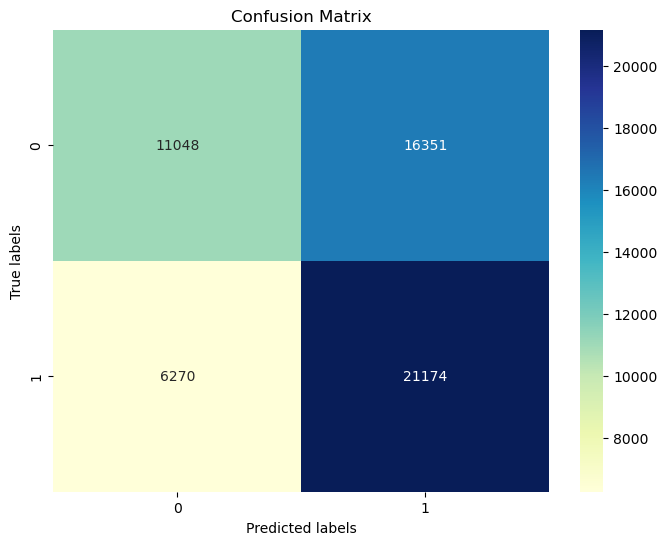

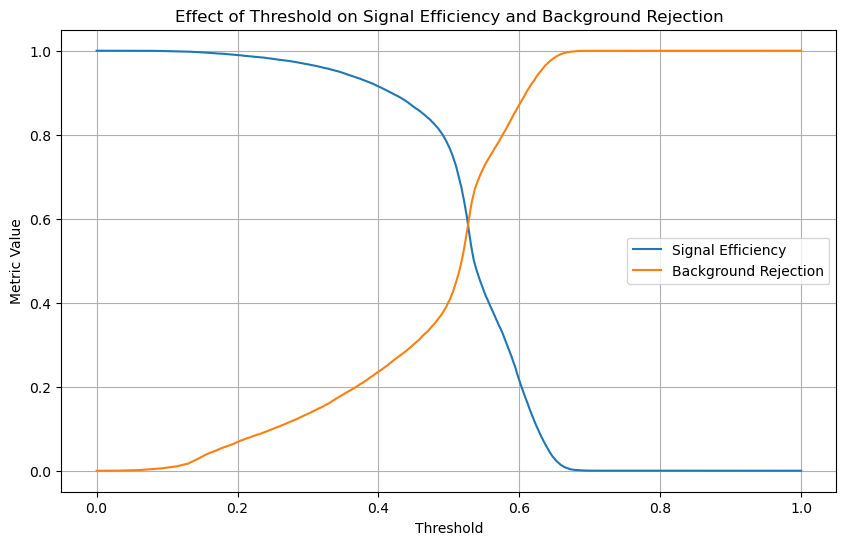

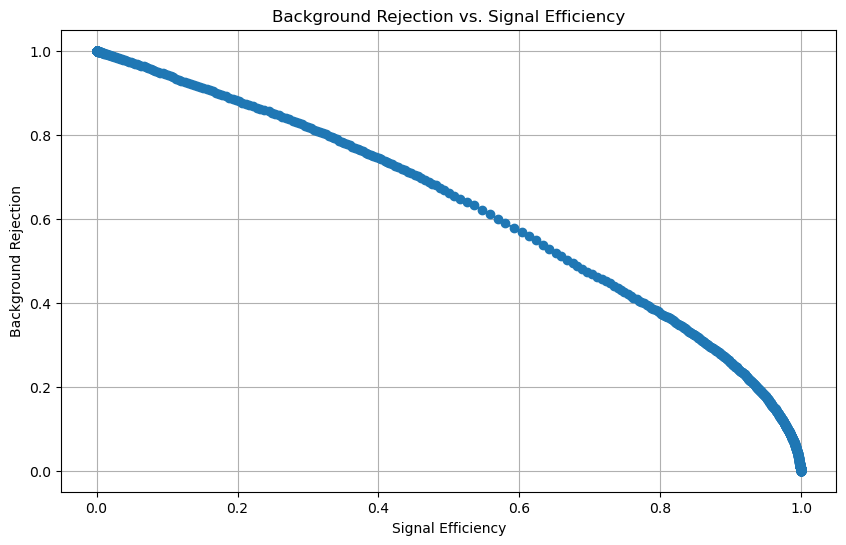

[(0.8725768838361755, 0.2938063432972006), (0.9003789535053199, 0.2574546516296215), (0.929857163678764, 0.21175955326836746), (0.960246319778458, 0.15204934486660096), (0.980141378807754, 0.1017190408409066), (0.990016032648302, 0.0677396985291434), (0.995008016324151, 0.0405489251432534), (0.9990161783996502, 0.007810504032993905)]


In [27]:
test_results = test_model(data, model, HYPERPARAMETERS)
metrics = getTargetMetrics(test_results)
displayPerformance(data, test_results, metrics, HYPERPARAMETERS)

In [18]:
def fold_batch_norm(dense_layer, bn_layer):
    W, b = dense_layer.get_weights()
    gamma, beta, moving_mean, moving_var = bn_layer.get_weights()

    epsilon = bn_layer.epsilon
    std = np.sqrt(moving_var + epsilon)
    new_W = gamma / std * W
    new_b = gamma / std * (b - moving_mean) + beta

    return new_W, new_b

def create_folded_model(original_model): # Fold batch normalization layers into dense layers
    inputs = original_model.input
    x = inputs
    new_layers = []

    for layer in original_model.layers:
        if isinstance(layer, QDense):
            next_layer = new_layers[-1] if new_layers else inputs
            if isinstance(next_layer, BatchNormalization):
                # Fold the BatchNormalization into the previous Dense layer
                new_W, new_b = fold_batch_norm(layer, next_layer)
                x = QDense(layer.units, weights=[new_W, new_b], kernel_quantizer=layer.kernel_quantizer, bias_quantizer=layer.bias_quantizer)(x)
                new_layers.pop()  # Remove the BatchNormalization layer
            else:
                x = layer(x)
        elif not isinstance(layer, BatchNormalization):
            x = layer(x)
        new_layers.append(x)

    outputs = x

    new_model = Model(inputs, outputs)
    return new_model

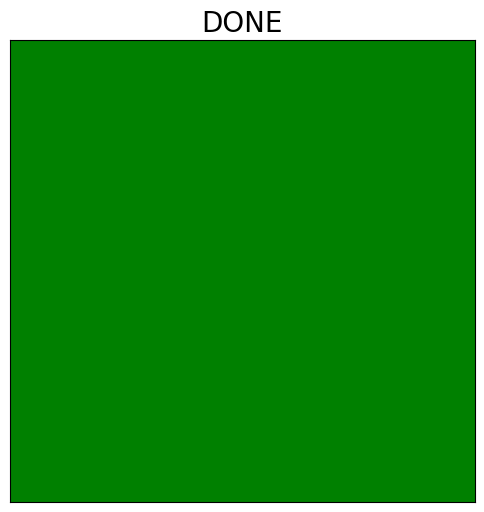

In [17]:
def showDone():
    fig, ax = plt.subplots()
    fig.set_size_inches(6, 6)
    square = plt.Rectangle((0, 0), 1, 1, color='green')
    ax.add_patch(square)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    plt.title("DONE", fontsize=20)

showDone()


In [28]:
# Create the folded model
new_model = create_folded_model(loaded_model)

# Verify the new model
new_model.summary()

new_model.save(f'./DNN_L2_S24_best_performance_single_quant_10_15new_folded.h5')


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 105), dtype=tf.float32, name='y_timed_input'), name='y_timed_input', description="created by layer 'y_timed_input'")


Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: KerasTensor(type_spec=TensorSpec(shape=(None, 105), dtype=tf.float32, name='y_timed_input'), name='y_timed_input', description="created by layer 'y_timed_input'")


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 y_timed_input (InputLayer)  multiple                     0         ['y_timed_input[0][0]']       
                                                                                                  
 dense1 (QDense)             (None, 24)                   2544      ['y_timed_input[1][0]']       
                                                                                                  
 q_activation_32 (QActivati  (None, 24)                   0         ['dense1[1][0]']              
 on)                                                                                              
                                                                                                  
 dense2 (QDense)             (None, 12)                   300       ['q_activation_32[1][0]'

/sdf/home/a/alexyue/miniconda3/envs/SmartPixel/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1714/1714 [==============================] - 3s 2ms/step
[[0.30105942]
 [0.44341695]
 [0.41784704]
 [0.34261703]
 [0.39480978]
 [0.0527426 ]
 [0.48433354]
 [0.10639128]
 [0.33765462]
 [0.42171764]]


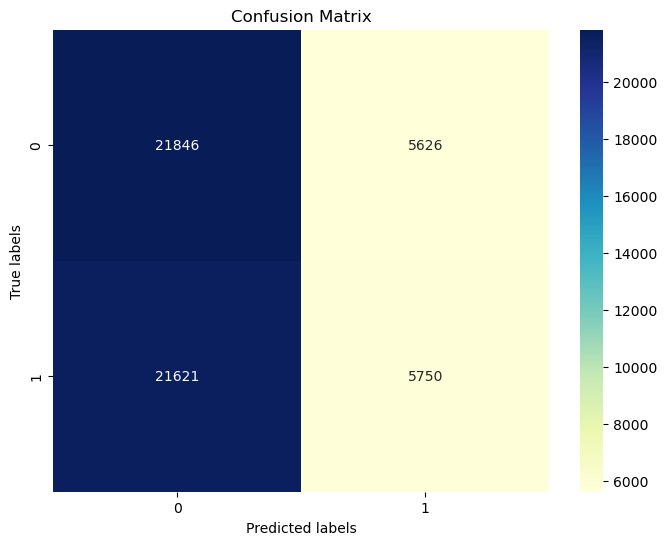

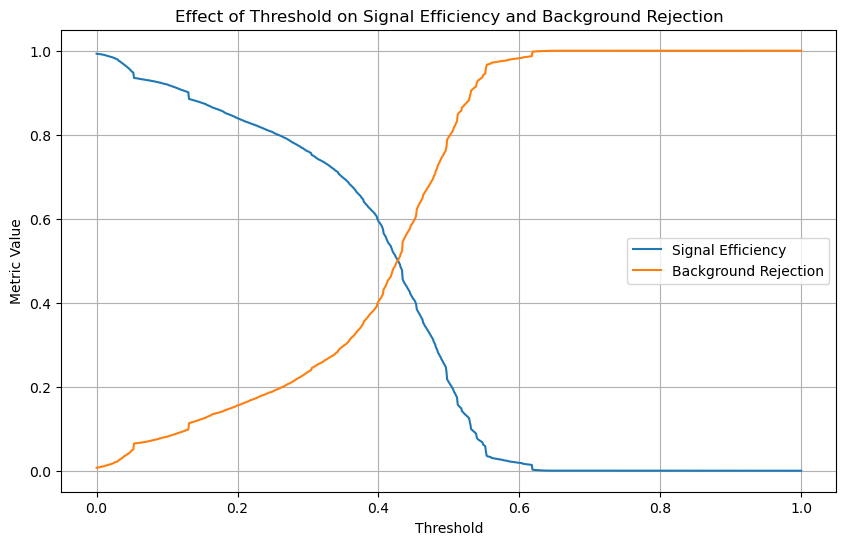

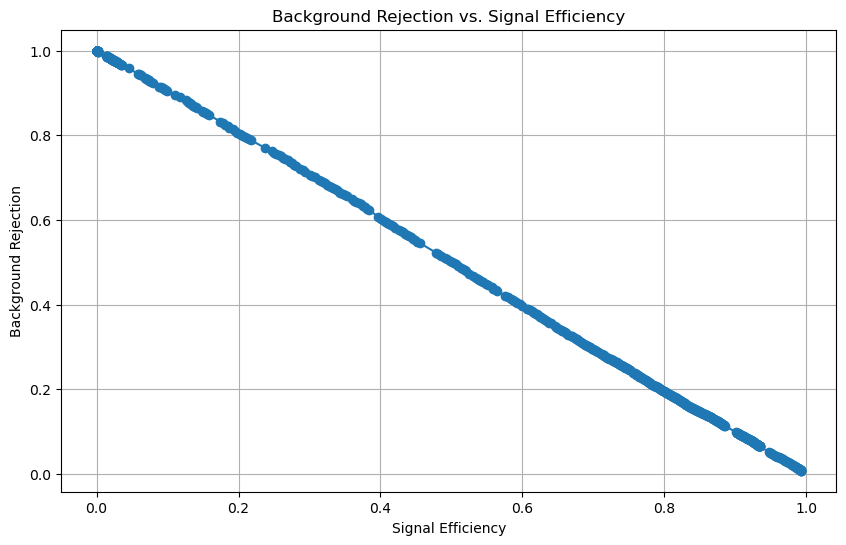

[(0.8726754594278616, 0.12620122306348283), (0.901063169047532, 0.0980270821199767), (0.92996236893062, 0.06934333139196272), (0.9602498995286982, 0.03956755969714618), (0.9797230645573782, 0.021731217239370996), (0.9899894048445435, 0.011138613861386138), (0.9928391363121551, 0.0071345369831100755), (0.9928391363121551, 0.0071345369831100755)]


In [29]:
test_results = test_model(data, new_model, HYPERPARAMETERS)
metrics = getTargetMetrics(test_results)
displayPerformance(data, test_results, metrics, HYPERPARAMETERS)

In [22]:
# Save the model when done
model.save(f'./DNN_L3_S32_best_performance_quant.h5')

In [11]:
# Load in a saved model from the h5 file
co = {}
_add_supported_quantized_objects(co)
co['PruneLowMagnitude'] = pruning_wrapper.PruneLowMagnitude
loaded_model = load_model('./hyperparam_search_recent_best.h5', custom_objects=co)
loaded_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 y_timed_input (InputLayer)  [(None, 105)]             0         
                                                                 
 dense1 (QDense)             (None, 24)                2544      
                                                                 
 batch_normalization_34 (Ba  (None, 24)                96        
 tchNormalization)                                               
                                                                 
 q_activation_34 (QActivati  (None, 24)                0         
 on)                                                             
                                                                 
 dense2 (QDense)             (None, 12)                300       
                                                                 
 batch_normalization_35 (Ba  (None, 12)                48 

1714/1714 [==============================] - 4s 2ms/step
[[0.60651195]
 [0.5104256 ]
 [0.6895442 ]
 [0.6159565 ]
 [0.29519528]
 [0.590249  ]
 [0.62142324]
 [0.65903014]
 [0.5956617 ]
 [0.5968334 ]]


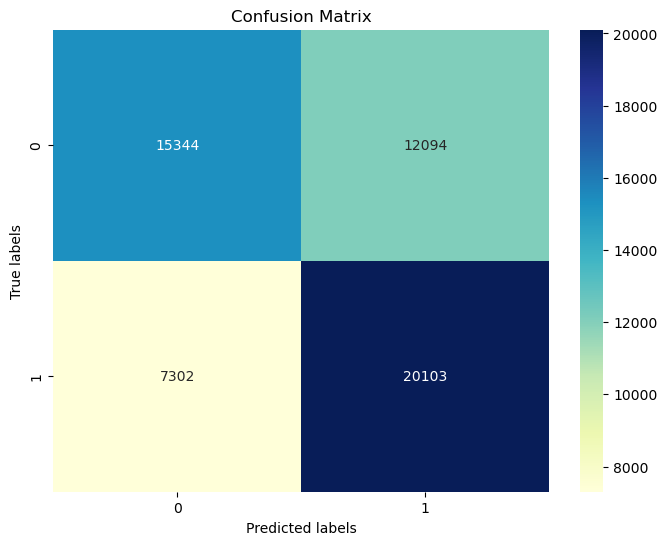

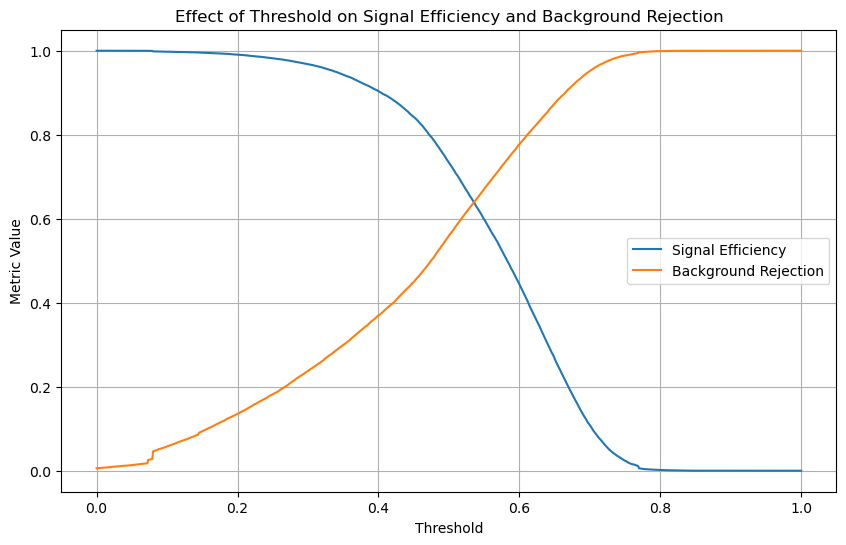

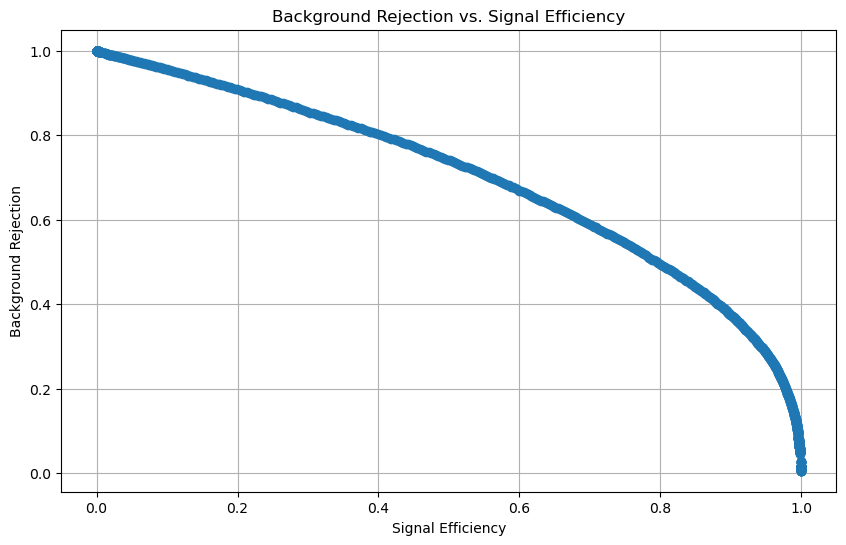

[(0.8723955482576172, 0.41453458706902835), (0.9002371829958037, 0.3737517311757417), (0.9301587301587302, 0.32458634011225307), (0.9598978288633461, 0.2610613018441577), (0.9799671592775041, 0.19112180188060354), (0.9899288451012589, 0.14100881988483124), (0.9950009122422916, 0.09913258983890955), (0.9984674329501916, 0.04621328085137401)]


In [15]:
test_results = test_model(data, loaded_model, HYPERPARAMETERS)
metrics = getTargetMetrics(test_results)
displayPerformance(data, test_results, metrics, HYPERPARAMETERS)

In [ ]:
# Write input data to file
with open('DNN_hp_input_features.dat', 'w') as file:
    for row in input_train_data_combined:
        line = ' '.join(map(str, row))  # Convert each number to string and join with space
        file.write(line + '\n')
# Write target data to file
with open('./DNN_hp_predictions_small.dat', 'w') as file:
    for score in target_test_data_coded:
        file.write(str(score[0]) + '\n')  # Convert number to string

# Dataset Display

In [14]:
# Data set display by time slice
def display_dataset(input_dataset, target_dataset, i, gif=False):
    # Extract the i-th data point from both datasets
    input_datapoint = input_dataset[i]
    target_datapoint = target_dataset[i]

    # Check if the index is valid
    if input_datapoint.shape != (20, 13, 21):
        raise ValueError(f"{input_datapoint.shape } is an invalid shape for the input data point")
    
    for i in range(8):
        for j in range(13):
            for k in range(21):
                print(input_datapoint[i, j, k], end=", ")
            print()
        print("--------", i)

    # Extracting the transverse momentum (pt) from the target_data dataset
    pt = target_datapoint[8]  # Assuming the 9th variable is at index 8

    fig, ax_main = plt.subplots(figsize=(8, 6))
    divider = make_axes_locatable(ax_main)

    # Add row sum plot as an inset to the main plot
    ax_row = divider.append_axes("right", size="20%", pad=0.4)

    # Add column sum plot below the main plot
    ax_column = divider.append_axes("bottom", size="20%", pad=0.5)

    # Initial plot
    im = ax_main.imshow(input_datapoint[0, :, :], cmap='plasma')
    ax_main.invert_yaxis()
    ax_main.set_yticks(np.arange(input_datapoint.shape[1]))
    ax_main.set_xticks(np.arange(input_datapoint.shape[2]))
    ax_main.grid(True, color='gray', alpha=0.7)

    # Function to update the animation
    def update(t):
        # Update main plot
        data = input_datapoint[t, :, :]
        im.set_data(data)

        # Update row sum plot
        ax_row.clear()
        ax_row.barh(np.arange(data.shape[0]), np.sum(data, axis=1), color='red')
        ax_row.set_ylim(0, data.shape[0]-1)
        ax_row.set_yticks(np.arange(data.shape[0]))
        ax_row.set_xlim(np.min(input_datapoint[:, :, :].sum(axis=2)) * 1.1, np.max(input_datapoint[:, :, :].sum(axis=2)) * 1.1)
        ax_row.set_xlabel("Row Sum")

        # Update column sum plot
        ax_column.clear()
        ax_column.bar(np.arange(data.shape[1]), np.sum(data, axis=0), color='blue')
        ax_column.set_xlim(0, data.shape[1]-1)
        ax_column.set_xticks(np.arange(data.shape[1]))
        ax_column.set_ylim(np.min(input_datapoint[:, :, :].sum(axis=1)) * 1.1, np.max(input_datapoint[:, :, :].sum(axis=1)) * 1.1)
        ax_column.set_ylabel("Column Sum")

        # Update labels and grid
        ax_main.set_xlabel("X Position")
        ax_main.set_ylabel("Y Position")

        # Update title for the entire figure
        fig.suptitle(f"Timestep: {t+1} | Data Point: {i} | pt: {pt:.2f} GeV")

    ani = FuncAnimation(fig, update, frames=20, repeat=True)

    gif_path = f"data_point.gif"
    if gif:
        # Save the animation as a GIF
        writer = PillowWriter(fps=1000 // FRAME_TIME)
        ani.save(gif_path, writer=writer)

    plt.close()
    return display(HTML(ani.to_jshtml())), gif_path

def display_model_IO(input_dataset_combined, target_dataset_coded, i):
    # Extract the i-th data point from both datasets
    input_datapoint = input_dataset_combined[i]
    target_datapoint = target_dataset_coded[i]

    # Check if the index is valid
    if (MODEL_TYPE == "DNN"):
        if input_datapoint.shape != (NUM_TIME_SLICES * 13 + 1,):
            raise ValueError(f"{input_datapoint.shape } is an invalid shape for the input data point 2")
        input_datapoint = input_datapoint[:-1].reshape(NUM_TIME_SLICES, 13)
    elif (MODEL_TYPE == "CNN"):
        if input_datapoint[0].shape != (NUM_TIME_SLICES, 13):
            raise ValueError(f"{input_datapoint.shape } is an invalid shape for the input data point 3")
        input_datapoint = input_datapoint[0]
        
    # Extracting the label from the target datapoint
    if target_datapoint[0] == 1:
        label = f"High p_t (over {TEST_PT_THRESHOLD} GeV)"
    elif target_datapoint[1] == 1:
        label = f"low p_t and negative charge"
    elif target_datapoint[2] == 1:
        label = f"low p_t and positive charge"
    else: 
        raise ValueError("Invalid labelling for the target data point")

    

    # Create the heatmap
    fig, ax_main = plt.subplots(figsize=(4,4))
    print(input_datapoint.shape)
    print(input_datapoint)
    im = ax_main.imshow(input_datapoint.T, cmap='coolwarm_r', vmin=-1, vmax=1)
    ax_main.invert_yaxis()
    ax_main.set_xticks(np.arange(input_datapoint.shape[0]))
    ax_main.set_yticks(np.arange(input_datapoint.shape[1]))
    ax_main.grid(True, color='gray', alpha=0.7)


    # Update labels and grid
    ax_main.set_xlabel("Time Slice")
    ax_main.set_ylabel("Y Position")


    # Update title for the entire figure
    fig.suptitle(f"Data Point: {i} | label: {label}")

In [14]:
# DATASET DISPLAY
rand_idx = random.randint(0, 100)
FRAME_TIME = 120  # milliseconds between frames
display_model_IO(input_data_combined_example, target_data_coded_example, rand_idx)
animation, gif = display_dataset(input_data_example, target_data_example, rand_idx, gif=False)

NameError: name 'display_model_IO' is not defined

# C++ Synthesis

In [35]:
import hls4ml
import os
os.environ['XILINX_HLS'] = '/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2023.1/Vitis_HLS/2023.1'
os.environ['XILINX_VIVADO'] = '/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2023.1/Vivado/2023.1'
os.environ['XILINX_VITIS'] = '/afs/slac.stanford.edu/g/reseng/vol39/xilinx/2023.1/Vitis/2023.1'
os.environ['XILINX_AP_INCLUDE'] = '/fs/ddn/sdf/group/atlas/d/hjia625/Smart_Pixel/HLS_arbitrary_Precision_Types/include'
os.environ['PATH'] = os.environ['XILINX_HLS'] + '/bin:' + os.environ['PATH']
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
os.environ['PATH'] = os.environ['XILINX_VITIS'] + '/bin:' + os.environ['PATH']
os.environ['PATH'] = os.environ['XILINX_AP_INCLUDE'] + '/bin:' + os.environ['PATH']

In [ ]:
from tensorflow_model_optimization.sparsity.keras import strip_pruning
strip_model = strip_pruning(qmodel_pruned)
hls_config = hls4ml.utils.config_from_keras_model(strip_model , granularity='name')

# Set the precision and reuse factor for the full model
hls_config['Model']['Precision'] = 'ap_fixed<10,2,AP_RND_ZERO,AP_SAT>'
hls_config['Model']['ReuseFactor'] = 1

for Layer in hls_config['LayerName'].keys():
    print(Layer)
    hls_config['LayerName'][Layer]['Strategy'] = 'Resource'
    hls_config['LayerName'][Layer]['ReuseFactor'] = 1
    hls_config['LayerName'][Layer]['Precision'] = 'ap_fixed<10,2,AP_RND_ZERO,AP_SAT>'

# If you want best numerical performance for high-accuray models, while the default latency strategy is faster but numerically more unstable
hls_config['LayerName']['output_sigmoid']['Strategy'] = 'Stable'
hls_config['LayerName']['output_sigmoid']['Precision'] = 'ap_fixed<32,8,AP_RND_ZERO,AP_SAT>'

cfg = hls4ml.converters.create_config(backend='Vitis')

cfg['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg['HLSConfig'] = hls_config
cfg['KerasModel'] = model
cfg['OutputDir'] = 'cnn_debug/'
cfg['XilinxPart'] = 'xcku040-ffva1156-2-e'

hls_model = hls4ml.converters.keras_to_hls(cfg)
hls_model.compile()
#hls_model.profile()
hls_model.build()

In [ ]:
for layer in qmodel_pruned.layers:
    for i, w in enumerate(layer.weights):
        try:
            print("weight is", w.numpy(), "for layer number", i)  # TF 2.x
        except Exception:
            print("weight is", layer.get_weights()[i], "for layer number", i) 